In [50]:
! pip install kagglehub


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
import kagglehub

DATASET_PATH = kagglehub.dataset_download("brycecf/give-me-some-credit-dataset")

In [52]:
import numpy as np
import scipy as sp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

## 1. Чтение данных и повтор методички

In [53]:
import pandas as pd

train = pd.read_csv(DATASET_PATH + "/cs-training.csv")
train.drop(columns=['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1, inplace=True)

test = pd.read_csv(DATASET_PATH + "/cs-test.csv")
test.drop(columns=['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1, inplace=True)

df = pd.concat([train, test])
df.shape

(251503, 10)

In [54]:
df.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [55]:
np.set_printoptions(precision=10, threshold= 10000, suppress= True)

### Очистка строк  с пропусками

In [56]:
df_clean = df.dropna()
print("Размерность после удаления NaN:", df_clean.shape)

Размерность после удаления NaN: (201669, 10)


### Выполнение РСА

In [57]:
df_clean = scale(df_clean)
pca = PCA(svd_solver='full')
pca.fit(df_clean)

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",None
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'full'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized S

In [58]:
explained = pca.explained_variance_ratio_
print("Вклад каждого фактора в объяснение вариации:\n", explained)

cum_explained = np.round(np.cumsum(explained), 4)
print("\nНакопленный вклад вариации:\n", cum_explained)


Вклад каждого фактора в объяснение вариации:
 [0.2979766397 0.1496007962 0.1217110055 0.1007219879 0.0999739517
 0.0975640598 0.0735527529 0.055468798  0.0024871325 0.0009428757]

Накопленный вклад вариации:
 [0.298  0.4476 0.5693 0.67   0.77   0.8675 0.9411 0.9966 0.9991 1.    ]


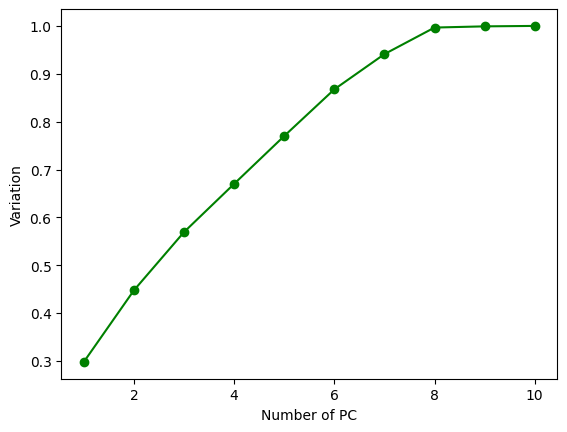

In [59]:
plt.figure()
plt.plot(np.arange(1,11), cum_explained, marker='o', color = 'green')
plt.ylabel('Variation')
plt.xlabel('Number of PC')
plt.show()

После очистки данных и стандартизации признаков метод главных компонентов показал, что уже первые несколько новых факторов содержат почти всю важную информацию: первая компонента объясняет около трети разброса, две вместе — почти половину, а примерно 5–6 компонент дают больше 80% всей вариативности. Это означает, что исходные признаки частично повторяют друг друга, и данные можно упростить — заменить 10 исходных столбцов несколькими более ёмкими компонентами, практически не потеряв смысла.

## 2. Анализ главных компонент по данным с домами

### a) Описание исследуемых данных

In [60]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [61]:
import pandas as pd
file_path = 'kc_house_data.csv'

In [62]:
main_df = pd.read_csv(file_path, sep=';', parse_dates=["date"], date_format='%d.%m.%Y %H:%M')
print(main_df.shape)
main_df.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Набор данных kc_house_data содержит 21 признак (столбец) для каждого из 21 613 наблюдений (домов).

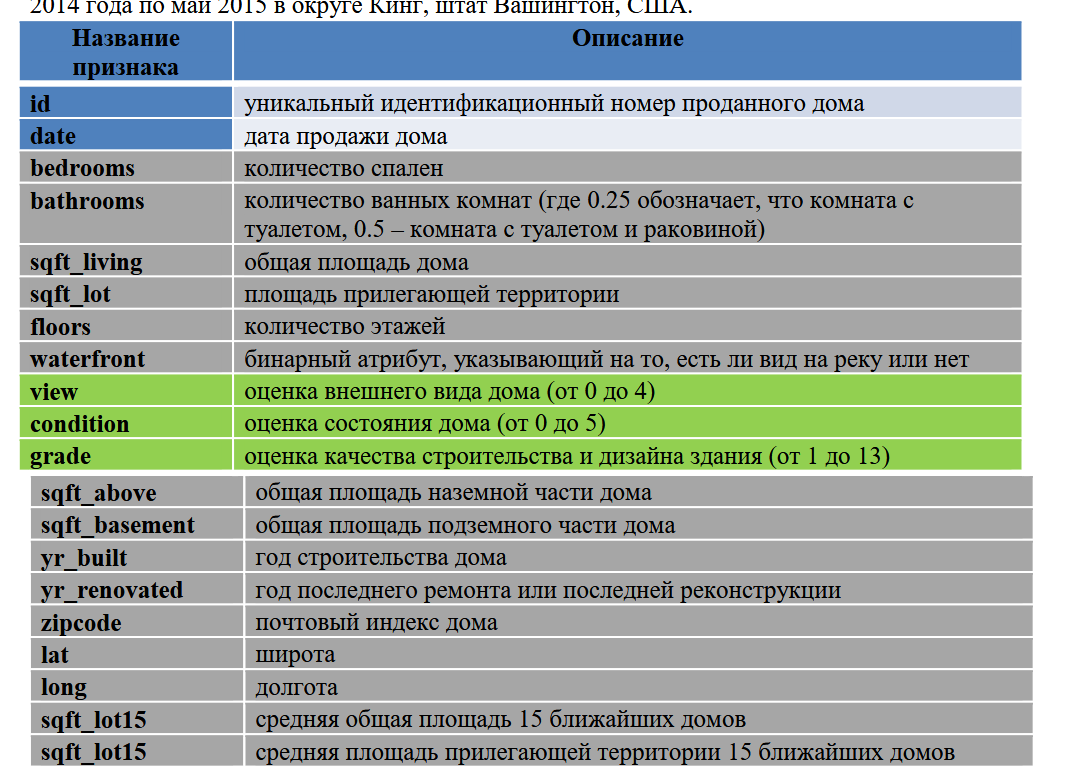

b) анализ главных компонентов

In [63]:
print("Названия столбцов:")
print(main_df.columns.tolist())
print("\nТипы данных столбцов:")
print(main_df.dtypes)

Названия столбцов:
['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

Типы данных столбцов:
id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object


In [64]:
main_df['date'] = pd.to_datetime(main_df['date'])

main_df['date'].min(), main_df['date'].max()

(Timestamp('2014-05-02 00:00:00'), Timestamp('2015-05-27 00:00:00'))

In [65]:
main_df.drop(['id', 'date', 'zipcode'], axis=1, inplace=True) # Удаляем столбцы 'id' и 'date' и 'zipcode'

In [66]:
main_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


In [67]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(main_df)

In [68]:
pca = PCA(svd_solver='full')
pca.fit(data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
print("\nВклад каждого фактора в объяснение вариации:\n", explained_variance_ratio)

cumulative_variance_ratio = np.round(np.cumsum(explained_variance_ratio), decimals=4)
print("\nРост доли объясненной вариации с увеличением числа главных факторов:\n", cumulative_variance_ratio)


Вклад каждого фактора в объяснение вариации:
 [0.3104646752 0.1244823711 0.1002833094 0.0733285103 0.0623412206
 0.0557056514 0.0477582115 0.0432509288 0.0366596299 0.0329086116
 0.0283872965 0.0184501535 0.0165571058 0.0147237651 0.0133947246
 0.0110684303 0.0102354043 0.          ]

Рост доли объясненной вариации с увеличением числа главных факторов:
 [0.3105 0.4349 0.5352 0.6086 0.6709 0.7266 0.7744 0.8176 0.8543 0.8872
 0.9156 0.934  0.9506 0.9653 0.9787 0.9898 1.     1.    ]


In [69]:
print(explained_variance_ratio[0])

0.31046467519273535


In [70]:
print(explained_variance_ratio[1])

0.12448237107100404


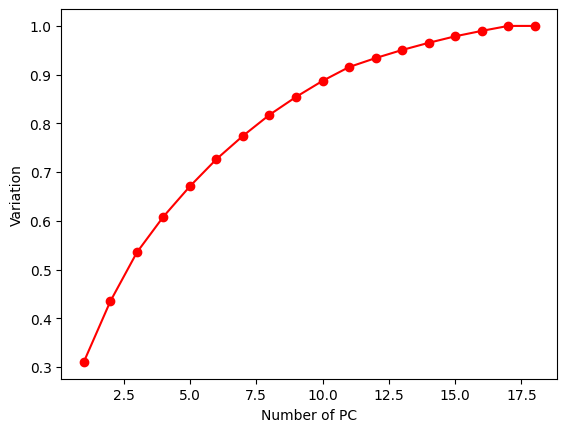

In [71]:
plt.figure()
plt.plot(np.arange(1,len(cumulative_variance_ratio)+1), cumulative_variance_ratio, color='red', marker='o', linestyle='solid')
plt.ylabel('Variation')
plt.xlabel('Number of PC')
plt.show()

8 главных компонент объясняют более 80% дисперсии


Компоненты (нагрузки) для первых двух главных компонент:
                  PC1     PC2
price          0.3079  0.2929
bedrooms       0.2371  0.0900
bathrooms      0.3526 -0.0212
sqft_living    0.3933  0.1127
sqft_lot       0.0913 -0.0990
floors         0.2220 -0.2629
waterfront     0.0639  0.2282
view           0.1359  0.3324
condition     -0.0700  0.2896
grade          0.3654  0.0019
sqft_above     0.3793 -0.1064
sqft_basement  0.1065  0.4330
yr_built       0.2109 -0.4151
yr_renovated   0.0163  0.1847
lat            0.0299  0.2051
long           0.1444 -0.3296
sqft_living15  0.3470  0.0265
sqft_lot15     0.0964 -0.1049


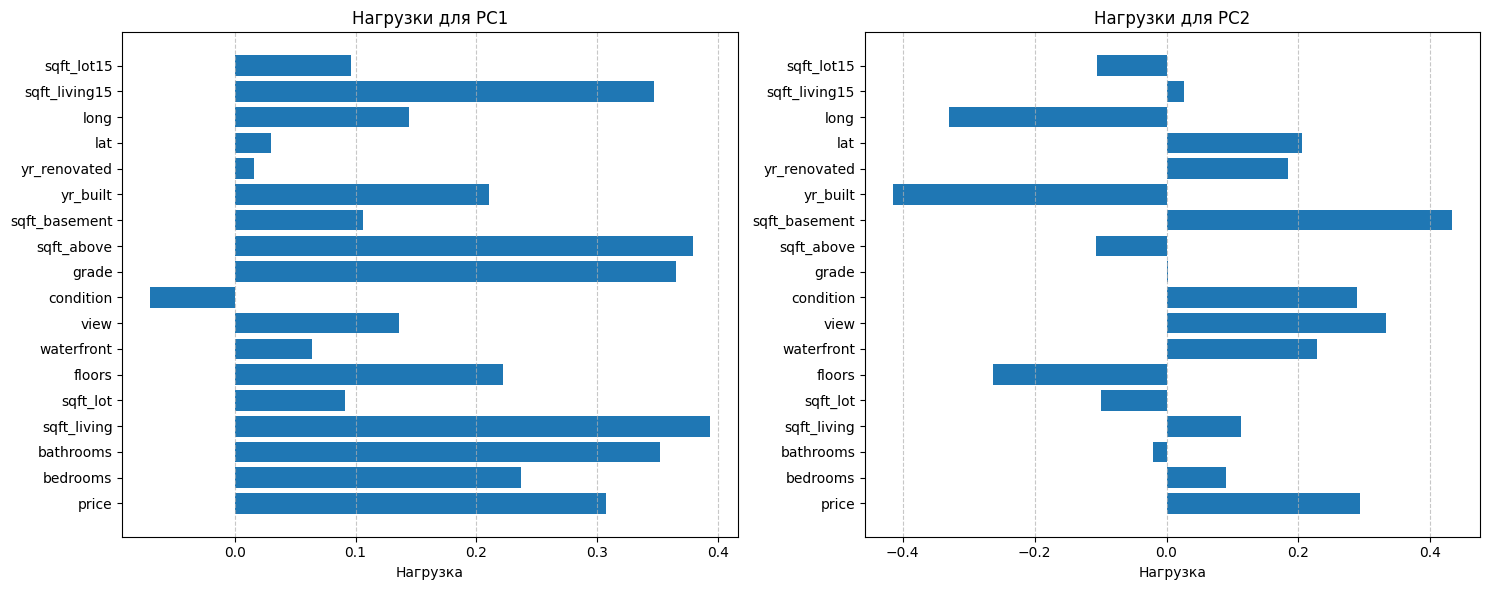

In [72]:
components = pca.components_

components_df = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(len(components))], index=main_df.columns)

print("\nКомпоненты (нагрузки) для первых двух главных компонент:")
print(components_df[['PC1', 'PC2']].round(4))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PC1
axes[0].barh(components_df.index, components_df['PC1'])
axes[0].set_xlabel('Нагрузка')
axes[0].set_title('Нагрузки для PC1')
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# PC2
axes[1].barh(components_df.index, components_df['PC2'])
axes[1].set_xlabel('Нагрузка')
axes[1].set_title('Нагрузки для PC2')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



Первая главная компонента (PC1) объясняет наибольшую часть общей дисперсии (около 30%). Она в основном отражает "Размер/Масштаб недвижимости" – тесно связана с площадью дома (sqft_living, sqft_above), количеством комнат (bedrooms, bathrooms), оценкой качества (grade) и, косвенно, ценой (price).

Вторая главная компонента (PC2) объясняет следующую по величине часть дисперсии (около 12.7%) и описывает "Качество/Состояние/Расположение/Особенности" дома, ортогональную фактору размера. Она связана с такими признаками, как view, waterfront, condition, yr_built, lat, long и др. Например, отрицательная нагрузка yr_built означает, что в рамках этого фактора (PC2) более высокие значения (например, связанные с хорошим видом или расположением на берегу) ассоциируются со старыми домами, а низкие значения – с новыми.

c) сравним дома по бинарному признаку "вид на водоём"

In [73]:
data_waterfront = main_df[main_df['waterfront'] == 1]
data_no_waterfront = main_df[main_df['waterfront'] == 0]

print(f"Количество домов с видом на водоём: {len(data_waterfront)}")
print(f"Количество домов без вида на водоём: {len(data_no_waterfront)}")

Количество домов с видом на водоём: 163
Количество домов без вида на водоём: 21450


слишком маленькая выборка, будут шумы в РСА

сравним дома по 'grade'

In [74]:
high_grade_mask = main_df['grade'] >= 10
medium_grade_mask = main_df['grade'] == 7

data_high_grade = main_df[high_grade_mask]
data_medium_grade = main_df[medium_grade_mask]

print(f"Количество домов с grade >= 10: {len(data_high_grade)}")
print(f"Количество домов с grade == 7: {len(data_medium_grade)}")


Количество домов с grade >= 10: 1636
Количество домов с grade == 7: 8981


Дома с grade >= 10
Вклад PC1: 0.2154 (21.54%)
Вклад PC2: 0.1618 (16.18%)
Объясненная дисперсия накопленными PC: [0.2154 0.3772 0.477  0.5528 0.6262 0.6913 0.7501 0.8051 0.8432 0.8779
 0.9055 0.931  0.9521 0.9694 0.9861 1.     1.    ]

Нагрузки для PC1 и PC2 (дома с grade >= 10):
               PC1_HG  PC2_HG
price          0.4121 -0.1522
bedrooms       0.2881  0.0924
bathrooms      0.3954  0.1398
sqft_living    0.4755  0.1529
sqft_lot       0.0500  0.2793
floors         0.0365  0.1398
waterfront     0.1548 -0.1766
view           0.2323 -0.2670
condition      0.0996 -0.2808
sqft_above     0.3379  0.3332
sqft_basement  0.2881 -0.2255
yr_built      -0.0959  0.3851
yr_renovated   0.0974 -0.2263
lat            0.0219 -0.1042
long          -0.0648  0.4239
sqft_living15  0.2213  0.1411
sqft_lot15     0.0593  0.2732


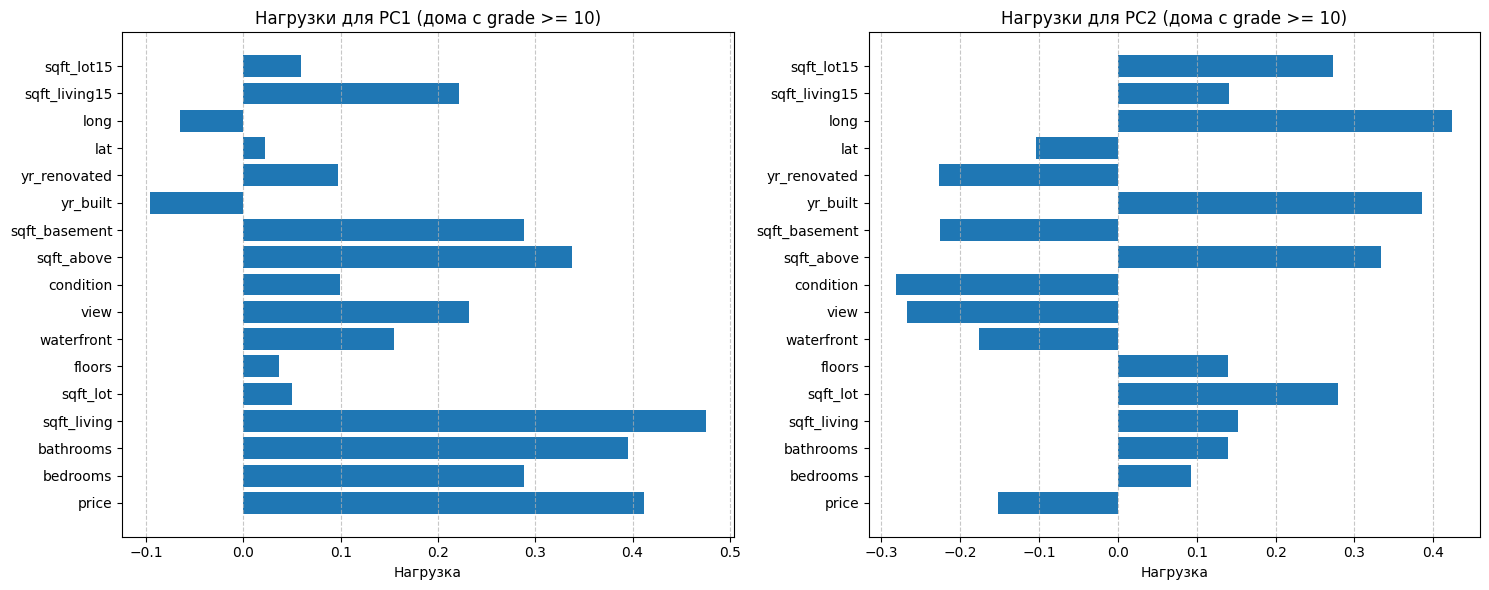

In [75]:
data_hg = data_high_grade.drop(columns=['grade'])
scaler_hg = StandardScaler()
data_hg_scaled = scaler_hg.fit_transform(data_hg)

pca_hg = PCA(svd_solver='full')
pca_hg.fit(data_hg_scaled)

explained_var_ratio_hg = pca_hg.explained_variance_ratio_
cumulative_var_ratio_hg = np.round(np.cumsum(explained_var_ratio_hg), decimals=4)

print("Дома с grade >= 10")
print(f"Вклад PC1: {explained_var_ratio_hg[0]:.4f} ({explained_var_ratio_hg[0]*100:.2f}%)")
print(f"Вклад PC2: {explained_var_ratio_hg[1]:.4f} ({explained_var_ratio_hg[1]*100:.2f}%)")
print(f"Объясненная дисперсия накопленными PC: {cumulative_var_ratio_hg}")

components_hg_df = pd.DataFrame(pca_hg.components_.T, columns=[f'PC{i+1}_HG' for i in range(len(pca_hg.components_))], index=data_hg.columns)
print("\nНагрузки для PC1 и PC2 (дома с grade >= 10):")
print(components_hg_df[['PC1_HG', 'PC2_HG']].round(4))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].barh(components_hg_df.index, components_hg_df['PC1_HG'])
axes[0].set_xlabel('Нагрузка')
axes[0].set_title('Нагрузки для PC1 (дома с grade >= 10)')
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].barh(components_hg_df.index, components_hg_df['PC2_HG'])
axes[1].set_xlabel('Нагрузка')
axes[1].set_title('Нагрузки для PC2 (дома с grade >= 10)')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Основной фактор (PC1): Остается "Размер/Ценность". Даже в премиальном сегменте, размер дома (sqft_living, bedrooms, bathrooms) и цена (price) тесно коррелируют друг с другом.

Вторичный фактор (PC2): Описывает более тонкие различия, связанные с местоположением и возрастом дома против эстетического качества (вид, состояние). Это говорит о том, что в этой группе покупатели могут выбирать между "новым домом в хорошем районе" и "старым домом с потрясающим видом".

теперь для grade = 7


--- Дома с grade == 7 ---
Вклад PC1: 0.2017 (20.17%)
Вклад PC2: 0.1484 (14.84%)
Объясненная дисперсия накопленными PC: [0.2017 0.35   0.4597 0.5474 0.6216 0.682  0.7392 0.7875 0.8305 0.8695
 0.9036 0.9295 0.9508 0.9706 0.9856 1.     1.    ]

Нагрузки для PC1 и PC2 (дома с grade == 7):
               PC1_MG  PC2_MG
price          0.1001  0.4598
bedrooms       0.3054  0.1714
bathrooms      0.4120  0.0126
sqft_living    0.4512  0.2423
sqft_lot       0.1381 -0.0679
floors         0.2359 -0.1945
waterfront     0.0366  0.1075
view           0.0601  0.1678
condition     -0.0486  0.2323
sqft_above     0.4293 -0.0746
sqft_basement  0.1081  0.4063
yr_built       0.2366 -0.4197
yr_renovated   0.0156  0.1050
lat           -0.1037  0.3230
long           0.2175 -0.2943
sqft_living15  0.3343  0.0995
sqft_lot15     0.1392 -0.0745


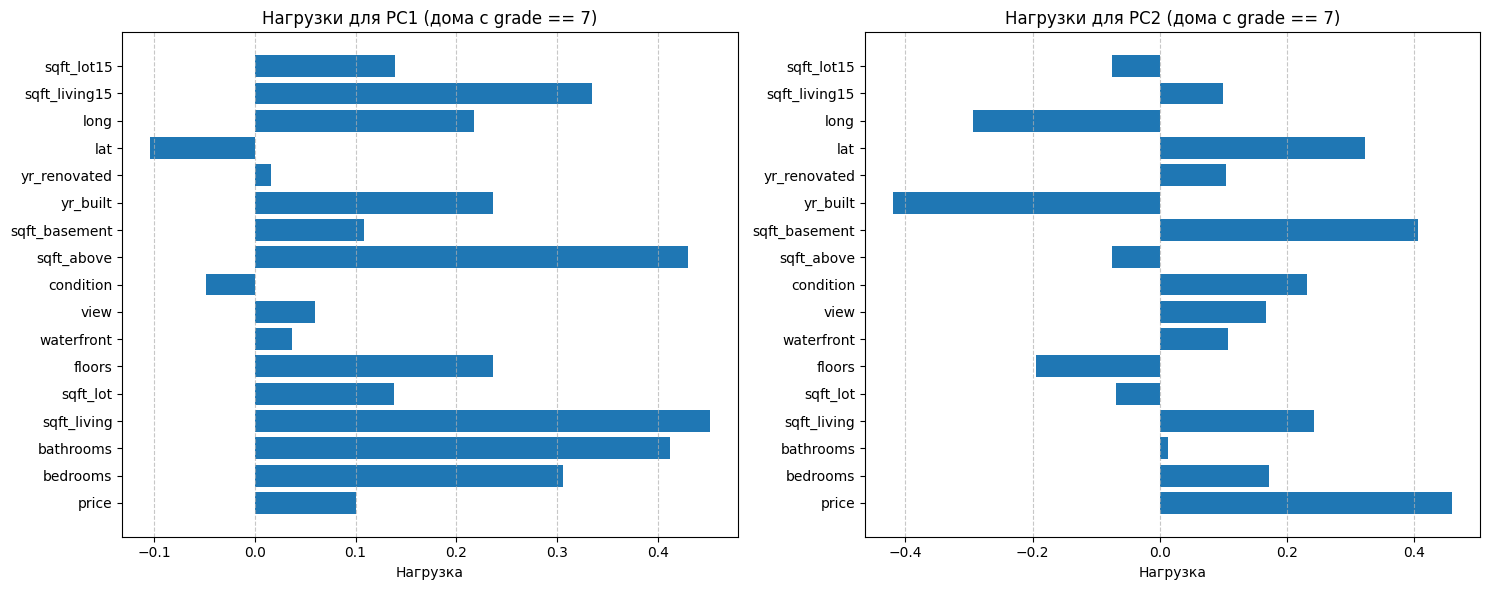

In [76]:
data_mg = data_medium_grade.drop(columns=['grade'])
scaler_mg = StandardScaler()
data_mg_scaled = scaler_mg.fit_transform(data_mg)

pca_mg = PCA(svd_solver='full')
pca_mg.fit(data_mg_scaled)

explained_var_ratio_mg = pca_mg.explained_variance_ratio_
cumulative_var_ratio_mg = np.round(np.cumsum(explained_var_ratio_mg), decimals=4)

print("\n--- Дома с grade == 7 ---")
print(f"Вклад PC1: {explained_var_ratio_mg[0]:.4f} ({explained_var_ratio_mg[0]*100:.2f}%)")
print(f"Вклад PC2: {explained_var_ratio_mg[1]:.4f} ({explained_var_ratio_mg[1]*100:.2f}%)")
print(f"Объясненная дисперсия накопленными PC: {cumulative_var_ratio_mg}")

components_mg_df = pd.DataFrame(pca_mg.components_.T, columns=[f'PC{i+1}_MG' for i in range(len(pca_mg.components_))], index=data_mg.columns)
print("\nНагрузки для PC1 и PC2 (дома с grade == 7):")
print(components_mg_df[['PC1_MG', 'PC2_MG']].round(4))

# Визуализация нагрузок для PC1_MG и PC2_MG
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].barh(components_mg_df.index, components_mg_df['PC1_MG'])
axes[0].set_xlabel('Нагрузка')
axes[0].set_title('Нагрузки для PC1 (дома с grade == 7)')
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].barh(components_mg_df.index, components_mg_df['PC2_MG'])
axes[1].set_xlabel('Нагрузка')
axes[1].set_title('Нагрузки для PC2 (дома с grade == 7)')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Сравнение показало, что основная структура данных, связанная с размером дома, сохраняется как в группе высококачественных (grade >= 10), так и в группе среднекачественных (grade == 7) домов. Однако вторичные факторы, описывающие оставшуюся вариацию, различаются между этими группами. Это свидетельствует о том, что влияние различных признаков на дифференциацию домов может зависеть от общего уровня качества

Вывод по пункту d):

PCA для всего набора данных показал, что основной фактор, объясняющий большую часть вариации, связан с размером дома. Этот вывод согласуется с результатами анализа подгрупп, где размер также является доминирующим фактором. Однако структура вторичных факторов (PC2) меняется в зависимости от выбранной подгруппы, что указывает на то, что влияние различных признаков на дифференциацию домов может зависеть от общего уровня качества (grade).

пункт e) для нестандартизированных данных

In [77]:
high_grade_mask = main_df['grade'] >= 10
medium_grade_mask = main_df['grade'] == 7

data_high_grade = main_df[high_grade_mask]
data_medium_grade = main_df[medium_grade_mask]

print(f"Количество домов с grade >= 10: {len(data_high_grade)}")
print(f"Количество домов с grade == 7: {len(data_medium_grade)}")

data_hg_no_grade = data_high_grade.drop(columns=['grade'])
data_mg_no_grade = data_medium_grade.drop(columns=['grade'])

Количество домов с grade >= 10: 1636
Количество домов с grade == 7: 8981


PCA для всего датасета (нестандартизованные данные)
Вклад PC1: 0.9822 (98.22%)
Вклад PC2: 0.0157 (1.57%)
Объясненная дисперсия накопленными PC: [0.9822 0.9979 1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.    ]

Нагрузки для PC1 и PC2 (весь датасет, нестандартизированные):
               PC1_unscaled  PC2_unscaled
price                0.9999       -0.0120
bedrooms             0.0000        0.0000
bathrooms            0.0000        0.0000
sqft_living          0.0018        0.0024
sqft_lot             0.0103        0.8697
floors               0.0000       -0.0000
waterfront           0.0000        0.0000
view                 0.0000        0.0000
condition            0.0000       -0.0000
grade                0.0000        0.0000
sqft_above           0.0014        0.0025
sqft_basement        0.0004       -0.0001
yr_built             0.0000        0.0000
yr_renovated         0.0001       -0.0000
lat                  0.0000       -0.0

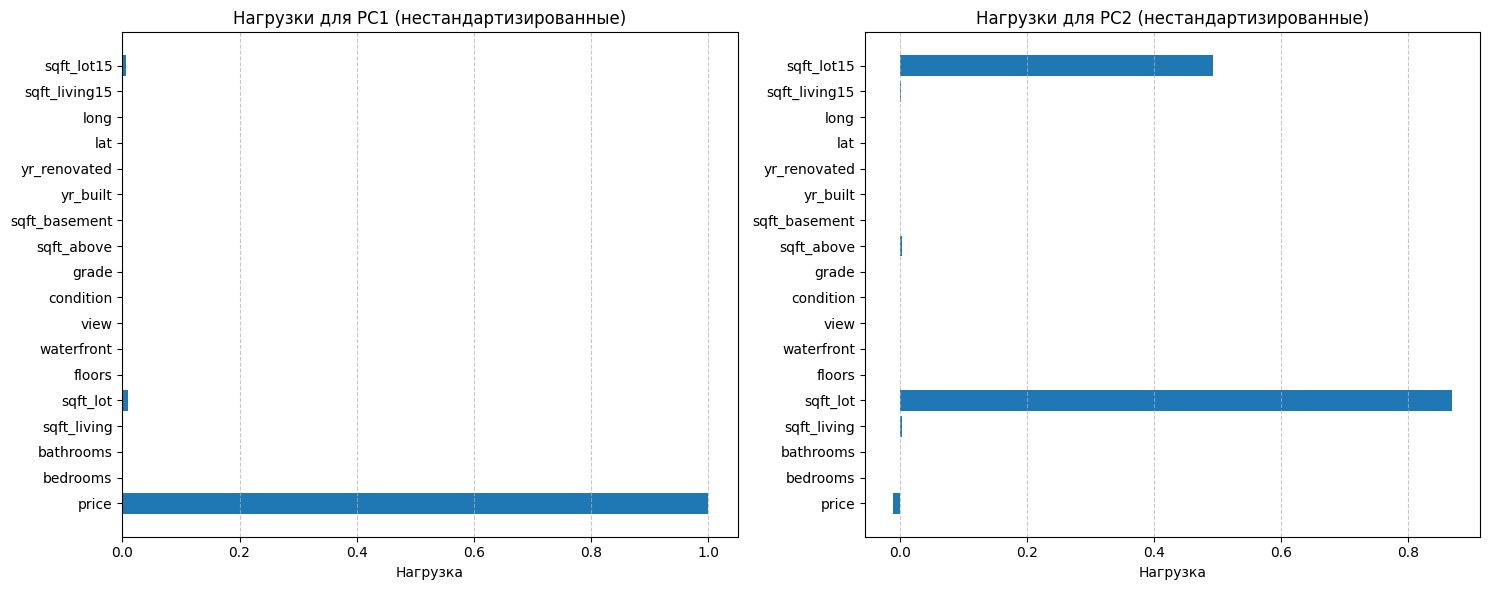

In [78]:
print("PCA для всего датасета (нестандартизованные данные)")
# Данные не стандартизируем
data_full_unscaled = main_df

pca_full_unscaled = PCA(svd_solver='full')
pca_full_unscaled.fit(data_full_unscaled)

explained_variance_ratio_full_unscaled = pca_full_unscaled.explained_variance_ratio_
cumulative_variance_ratio_full_unscaled = np.round(np.cumsum(explained_variance_ratio_full_unscaled), decimals=4)

print(f"Вклад PC1: {explained_variance_ratio_full_unscaled[0]:.4f} ({explained_variance_ratio_full_unscaled[0]*100:.2f}%)")
print(f"Вклад PC2: {explained_variance_ratio_full_unscaled[1]:.4f} ({explained_variance_ratio_full_unscaled[1]*100:.2f}%)")
print(f"Объясненная дисперсия накопленными PC: {cumulative_variance_ratio_full_unscaled}")

components_full_unscaled_df = pd.DataFrame(pca_full_unscaled.components_.T, columns=[f'PC{i+1}_unscaled' for i in range(len(pca_full_unscaled.components_))], index=main_df.columns)
print("\nНагрузки для PC1 и PC2 (весь датасет, нестандартизированные):")
print(components_full_unscaled_df[['PC1_unscaled', 'PC2_unscaled']].round(4))

# Визуализация нагрузок для PC1 и PC2
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].barh(components_full_unscaled_df.index, components_full_unscaled_df['PC1_unscaled'])
axes[0].set_xlabel('Нагрузка')
axes[0].set_title('Нагрузки для PC1 (нестандартизированные)')
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].barh(components_full_unscaled_df.index, components_full_unscaled_df['PC2_unscaled'])
axes[1].set_xlabel('Нагрузка')
axes[1].set_title('Нагрузки для PC2 (нестандартизированные)')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

PCA для группы grade >= 10 (нестандартизованные данные)
Вклад PC1: 0.9847 (98.47%)
Вклад PC2: 0.0135 (1.35%)
Объясненная дисперсия первыми 5 PC: [0.9847 0.9982 1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.    ]

Нагрузки для PC1 и PC2 (grade >= 10, нестандартизированные):
               PC1_HG_unscaled  PC2_HG_unscaled
price                   1.0000           0.0020
bedrooms                0.0000          -0.0000
bathrooms               0.0000           0.0000
sqft_living             0.0009           0.0023
sqft_lot               -0.0015           0.8785
floors                  0.0000          -0.0000
waterfront              0.0000          -0.0000
view                    0.0000          -0.0000
condition               0.0000          -0.0000
sqft_above              0.0006           0.0024
sqft_basement           0.0004          -0.0001
yr_built               -0.0000           0.0000
yr_renovated            0.0001          -0.0002
lat

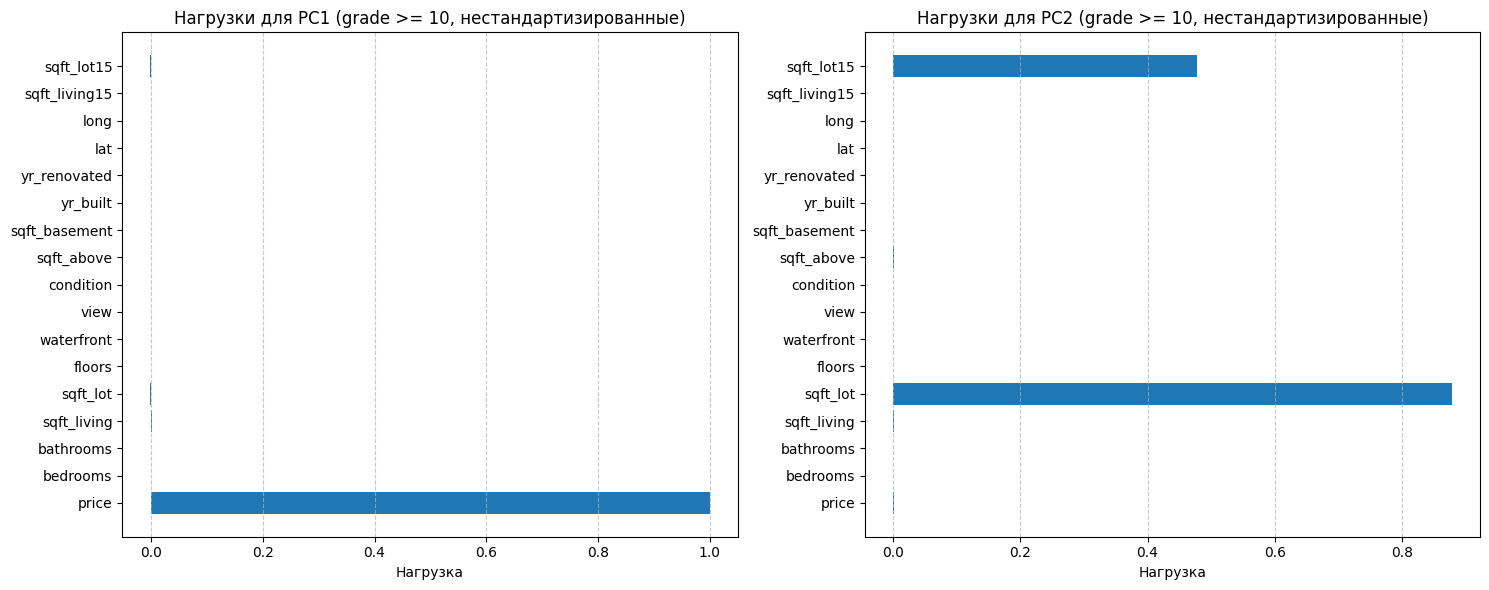

In [79]:
print("PCA для группы grade >= 10 (нестандартизованные данные)")
data_hg_unscaled = data_hg_no_grade

pca_hg_unscaled = PCA(svd_solver='full')
pca_hg_unscaled.fit(data_hg_unscaled)

explained_var_ratio_hg_unscaled = pca_hg_unscaled.explained_variance_ratio_
cumulative_var_ratio_hg_unscaled = np.round(np.cumsum(explained_var_ratio_hg_unscaled), decimals=4)

print(f"Вклад PC1: {explained_var_ratio_hg_unscaled[0]:.4f} ({explained_var_ratio_hg_unscaled[0]*100:.2f}%)")
print(f"Вклад PC2: {explained_var_ratio_hg_unscaled[1]:.4f} ({explained_var_ratio_hg_unscaled[1]*100:.2f}%)")
print(f"Объясненная дисперсия первыми 5 PC: {cumulative_var_ratio_hg_unscaled}")

components_hg_unscaled_df = pd.DataFrame(pca_hg_unscaled.components_.T, columns=[f'PC{i+1}_HG_unscaled' for i in range(len(pca_hg_unscaled.components_))], index=data_hg_no_grade.columns)
print("\nНагрузки для PC1 и PC2 (grade >= 10, нестандартизированные):")
print(components_hg_unscaled_df[['PC1_HG_unscaled', 'PC2_HG_unscaled']].round(4))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].barh(components_hg_unscaled_df.index, components_hg_unscaled_df['PC1_HG_unscaled'])
axes[0].set_xlabel('Нагрузка')
axes[0].set_title('Нагрузки для PC1 (grade >= 10, нестандартизированные)')
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].barh(components_hg_unscaled_df.index, components_hg_unscaled_df['PC2_HG_unscaled'])
axes[1].set_xlabel('Нагрузка')
axes[1].set_title('Нагрузки для PC2 (grade >= 10, нестандартизированные)')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

\PCA для группы grade == 7 (нестандартизованные данные)
Вклад PC1: 0.9485 (94.85%)
Вклад PC2: 0.0454 (4.54%)
Объясненная дисперсия первыми 5 PC: [0.9485 0.9939 1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.    ]

Нагрузки для PC1 и PC2 (grade == 7, нестандартизированные):
               PC1_MG_unscaled  PC2_MG_unscaled
price                   1.0000          -0.0041
bedrooms                0.0000           0.0000
bathrooms               0.0000           0.0000
sqft_living             0.0011           0.0015
sqft_lot                0.0049           0.8235
floors                  0.0000          -0.0000
waterfront              0.0000           0.0000
view                    0.0000           0.0000
condition               0.0000          -0.0000
sqft_above              0.0004           0.0016
sqft_basement           0.0007          -0.0001
yr_built               -0.0001           0.0001
yr_renovated            0.0003           0.0002
lat 

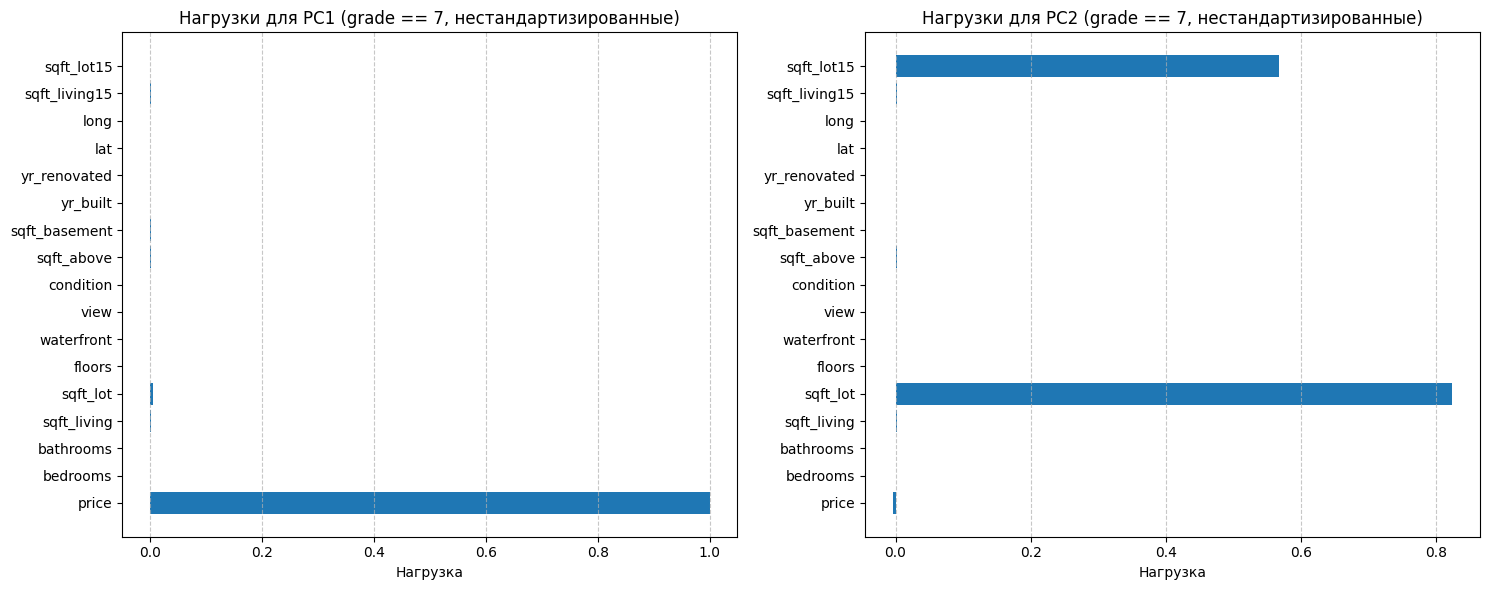

In [80]:
print("\PCA для группы grade == 7 (нестандартизованные данные)")
data_mg_unscaled = data_mg_no_grade

pca_mg_unscaled = PCA(svd_solver='full')
pca_mg_unscaled.fit(data_mg_unscaled)

explained_var_ratio_mg_unscaled = pca_mg_unscaled.explained_variance_ratio_
cumulative_var_ratio_mg_unscaled = np.round(np.cumsum(explained_var_ratio_mg_unscaled), decimals=4)

print(f"Вклад PC1: {explained_var_ratio_mg_unscaled[0]:.4f} ({explained_var_ratio_mg_unscaled[0]*100:.2f}%)")
print(f"Вклад PC2: {explained_var_ratio_mg_unscaled[1]:.4f} ({explained_var_ratio_mg_unscaled[1]*100:.2f}%)")
print(f"Объясненная дисперсия первыми 5 PC: {cumulative_var_ratio_mg_unscaled}")

components_mg_unscaled_df = pd.DataFrame(pca_mg_unscaled.components_.T, columns=[f'PC{i+1}_MG_unscaled' for i in range(len(pca_mg_unscaled.components_))], index=data_mg_no_grade.columns)
print("\nНагрузки для PC1 и PC2 (grade == 7, нестандартизированные):")
print(components_mg_unscaled_df[['PC1_MG_unscaled', 'PC2_MG_unscaled']].round(4))

# Визуализация нагрузок для PC1_MG и PC2_MG (нестандартизированные)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].barh(components_mg_unscaled_df.index, components_mg_unscaled_df['PC1_MG_unscaled'])
axes[0].set_xlabel('Нагрузка')
axes[0].set_title('Нагрузки для PC1 (grade == 7, нестандартизированные)')
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].barh(components_mg_unscaled_df.index, components_mg_unscaled_df['PC2_MG_unscaled'])
axes[1].set_xlabel('Нагрузка')
axes[1].set_title('Нагрузки для PC2 (grade == 7, нестандартизированные)')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

в целом по пунтку e можно сказать, что из-за отсутствии стандартизации РСА думает, что единственное, на что нужно обратить внимание - это price из-за огромного масштаба этой величины. Туда оно и улетает полностью)